In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from mstcn_model import *
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='6'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=8,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=4,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/mstcnnew-full-supervised-split4/",
    project_name="breakfast-split-4",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 8, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 4, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/mstcnnew-full-supervised-split4/', 'project_name': 'breakfast-split-4', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split4.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split4.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 1136
Number of videos not found in train fold is 0
Number of videos logged in test fold is 576
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, 
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4,
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)

In [9]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [10]:
loaded_vidid_selected_frames = np.load("/home/dipika16/ar/TimestampActionSeg/data/breakfast_annotation_all.npy", allow_pickle=True).item()
# loaded_vidid_selected_frames
video_id_boundary_frames = pickle.load(open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "rb"))
# video_id_boundary_frames

In [11]:
loaded_mean_var_actions = pickle.load(open("dump_dir/mean_var_actions.pkl", "rb"))
def get_possion_prob(cur_len, cur_class):
    mean_class, std_class = loaded_mean_var_actions[cur_class]
    mean_class = mean_class * 10
    prob = cur_len * torch.log(torch.tensor(mean_class, device=device) + 1e-5)
    prob = prob - mean_class
    factorials = torch.cumsum(torch.log(torch.arange(1, torch.max(cur_len)+1, 1).type(torch.float).to(device)), 
                              dim=0)[min(cur_len)-1:]
    prob = prob - factorials
    return prob

# get_possion_prob(torch.arange(10, 21), 20)

In [12]:
prob_video_each_segment_dict = {}

In [13]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):

        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[cur_ele]
        label_next_ele = labels[next_ele]

        indices = torch.arange(cur_ele, next_ele).to(cumsum_feat.device)
        strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
        end_index = cumsum_feat[next_ele - 1, :][None, :]
        left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
        right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]

        cur_boundary_len = indices - cur_boundary
        len_prob = get_possion_prob(cur_boundary_len, label_cur_ele.item())

        prob = torch.softmax((left_sum + right_sum + len_prob), dim=0)
#         prob = torch.softmax((left_sum + right_sum), dim=0)

        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob.detach().cpu().numpy()).item())
        prob_each_segment.append(prob)
    
    return prob_each_segment

In [14]:
def calculate_element_probb(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_video = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [15]:
def get_estimated_loss(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames[0]
        if start_ele_idx > 0:
            start_ele_label_idx = labels[selected_frames[0]]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob.unsqueeze(0))
        
        for i, cur_ele in enumerate(selected_frames[:-1]):
            next_ele = selected_frames[i + 1]
            label_cur_ele = labels[cur_ele]
            label_next_ele = labels[next_ele]

            indices = torch.arange(cur_ele, next_ele)
            strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
            end_index = cumsum_feat[next_ele - 1, :][None, :]
            left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
            right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]
            current_vid_prob_arr.append((left_sum + right_sum)  * (prob_each_video[i]))
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = labels[selected_frames[-1]]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames[-1] - 1, :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob.unsqueeze(0))
            
        loss_arr.append(torch.cat(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [16]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_estimated_boundaries():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames, video_id_boundary_frames
    estimated_boundary_dict = {}
    for ele in video_id_boundary_frames.keys():
        if (ele + ".txt") not in train_split_file_list:
            continue
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        selected_ele_list = loaded_vidid_selected_frames[ele + ".txt"]
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_ele_list[i], selected_ele_list[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_ele_list[i]) or (estimated_boundary > selected_ele_list[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [17]:

def get_boundary_err():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for ele in video_id_boundary_frames.keys():
        if (ele + ".txt") not in train_split_file_list:
            continue
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(video_id_boundary_frames[ele][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = video_id_boundary_frames[ele][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")

In [18]:
set_seed()
model = MultiStageModel(num_stages=4, num_layers=10, num_f_maps=64, dim=2048, num_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [19]:
def get_single_random(labels_all, video_ids):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((labels_all.shape[0], labels_all.shape[1]), dtype=torch.long, device=labels_all.device) * (-100)
    for iter_num, labels in enumerate(labels_all):
        cur_vidid = video_ids[iter_num]
        frame_idx_tensor = torch.from_numpy(np.array(loaded_vidid_selected_frames[cur_vidid + ".txt"]))
        boundary_target_tensor[iter_num, frame_idx_tensor] = labels[frame_idx_tensor]

    return boundary_target_tensor

In [20]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/mstcnnew-full-supervised-split4/'

In [21]:
initialize_epoch = 15
expectation_cal_gap = 5
best_val_acc = 0
for epoch in range(1000):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        middle_pred, predictions = model(item_0, src_mask_mse)
        
        loss = 0
        for p in predictions:
            loss += ce_criterion(p, item_2)
            loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), 
                                                                F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                                        max=16) * src_mask_mse[:, :, 1:])
            

        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(predictions[-1], dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")
    # Calculating Expectation Step
    model.eval()

    print("Calculating Validation Data Accuracy")
    correct = 0.0
    total = 0.0
    for i, item in enumerate(testloader):
        with torch.no_grad():
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

            middle_pred, predictions = model(item_0, src_mask_mse)

            pred = torch.argmax(predictions[-1], dim=1)
            correct += float(torch.sum((pred == item_2) * src_mask).item())
            total += float(torch.sum(src_mask).item())
    val_acc = correct * 100.0 / total
    if val_acc > best_val_acc:
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-best-model.wt")
    torch.save(model.state_dict(), config.output_dir + "ms-tcn-last-model.wt")
    print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

Starting Training
Training:: Epoch 0, Iteration 0, Current loss 15.722561836242676 Accuracy 3.737044714243411
Training:: Epoch 0, Iteration 10, Current loss 13.530548095703125 Accuracy 23.141452126120914
Training:: Epoch 0, Iteration 20, Current loss 13.128864288330078 Accuracy 0.8774082709534913
Training:: Epoch 0, Iteration 30, Current loss 12.450479507446289 Accuracy 19.317244791380354
Training:: Epoch 0, Iteration 40, Current loss 14.374771118164062 Accuracy 1.5980873285516548
Training:: Epoch 0, Iteration 50, Current loss 11.84317684173584 Accuracy 31.332837854576987
Training:: Epoch 0, Iteration 60, Current loss 12.652199745178223 Accuracy 13.702894231406054
Training:: Epoch 0, Iteration 70, Current loss 14.351591110229492 Accuracy 8.943959113329768
Training:: Epoch 0, Iteration 80, Current loss 11.659465789794922 Accuracy 10.758064516129032
Training:: Epoch 0, Iteration 90, Current loss 12.443076133728027 Accuracy 15.255775577557756
Training:: Epoch 0, Iteration 100, Current los

Training:: Epoch 5, Iteration 70, Current loss 4.773314476013184 Accuracy 50.60524150899048
Training:: Epoch 5, Iteration 80, Current loss 6.668547630310059 Accuracy 39.68072976054732
Training:: Epoch 5, Iteration 90, Current loss 4.948241710662842 Accuracy 61.53430942581472
Training:: Epoch 5, Iteration 100, Current loss 7.499157905578613 Accuracy 36.47749022218524
Training:: Epoch 5, Iteration 110, Current loss 5.376407623291016 Accuracy 50.15013211626231
Training:: Epoch 5, Iteration 120, Current loss 7.042083740234375 Accuracy 40.49944564700913
Training:: Epoch 5, Iteration 130, Current loss 4.917335033416748 Accuracy 63.2504548211037
Training:: Epoch 5, Iteration 140, Current loss 5.702054500579834 Accuracy 54.11630258010637
Calculating Validation Data Accuracy
Validation:: Epoch 5, Probability Accuracy 49.34909705292191
Starting Training
Training:: Epoch 6, Iteration 0, Current loss 5.21519660949707 Accuracy 68.49813748730105
Training:: Epoch 6, Iteration 10, Current loss 4.98893

Calculating Validation Data Accuracy
Validation:: Epoch 10, Probability Accuracy 53.132536813966105
Starting Training
Training:: Epoch 11, Iteration 0, Current loss 4.954178810119629 Accuracy 67.63485477178423
Training:: Epoch 11, Iteration 10, Current loss 5.0713210105896 Accuracy 63.31548415885765
Training:: Epoch 11, Iteration 20, Current loss 3.100390672683716 Accuracy 79.98162925541075
Training:: Epoch 11, Iteration 30, Current loss 4.185771942138672 Accuracy 73.13340227507756
Training:: Epoch 11, Iteration 40, Current loss 5.424829483032227 Accuracy 53.67817725356449
Training:: Epoch 11, Iteration 50, Current loss 5.473266124725342 Accuracy 62.954476015887565
Training:: Epoch 11, Iteration 60, Current loss 3.7783470153808594 Accuracy 78.60595475039604
Training:: Epoch 11, Iteration 70, Current loss 3.3842875957489014 Accuracy 78.64332194185666
Training:: Epoch 11, Iteration 80, Current loss 3.047518253326416 Accuracy 81.88976377952756
Training:: Epoch 11, Iteration 90, Current lo

Training:: Epoch 16, Iteration 60, Current loss 3.0693767070770264 Accuracy 85.24846190250828
Training:: Epoch 16, Iteration 70, Current loss 3.2262818813323975 Accuracy 78.56136505948653
Training:: Epoch 16, Iteration 80, Current loss 2.7120676040649414 Accuracy 84.63367350671203
Training:: Epoch 16, Iteration 90, Current loss 2.879209518432617 Accuracy 83.92449200432848
Training:: Epoch 16, Iteration 100, Current loss 2.5752837657928467 Accuracy 86.71246994160083
Training:: Epoch 16, Iteration 110, Current loss 2.8540892601013184 Accuracy 81.10187227784377
Training:: Epoch 16, Iteration 120, Current loss 2.4854822158813477 Accuracy 84.22286666255322
Training:: Epoch 16, Iteration 130, Current loss 2.413097858428955 Accuracy 85.86827296504715
Training:: Epoch 16, Iteration 140, Current loss 2.400545358657837 Accuracy 86.54295194789235
Calculating Validation Data Accuracy
Validation:: Epoch 16, Probability Accuracy 61.9752416682462
Starting Training
Training:: Epoch 17, Iteration 0, Cu

Training:: Epoch 22, Iteration 80, Current loss 1.5669827461242676 Accuracy 92.79663562631421
Training:: Epoch 22, Iteration 90, Current loss 3.738039016723633 Accuracy 77.42814507234154
Training:: Epoch 22, Iteration 100, Current loss 2.78122615814209 Accuracy 84.03939346568704
Training:: Epoch 22, Iteration 110, Current loss 1.9842180013656616 Accuracy 90.67087225524688
Training:: Epoch 22, Iteration 120, Current loss 2.202498197555542 Accuracy 87.1570209822458
Training:: Epoch 22, Iteration 130, Current loss 1.6371365785598755 Accuracy 92.35311840915938
Training:: Epoch 22, Iteration 140, Current loss 2.7976722717285156 Accuracy 84.0042002100105
Calculating Validation Data Accuracy
Validation:: Epoch 22, Probability Accuracy 65.80909025549187
Starting Training
Training:: Epoch 23, Iteration 0, Current loss 2.2027781009674072 Accuracy 89.46955583880772
Training:: Epoch 23, Iteration 10, Current loss 2.207719564437866 Accuracy 91.59157028311928
Training:: Epoch 23, Iteration 20, Curre

Calculating Validation Data Accuracy
Validation:: Epoch 27, Probability Accuracy 67.98099987581618
Starting Training
Training:: Epoch 28, Iteration 0, Current loss 1.6177830696105957 Accuracy 93.42869112454366
Training:: Epoch 28, Iteration 10, Current loss 1.8444932699203491 Accuracy 92.82852564102564
Training:: Epoch 28, Iteration 20, Current loss 1.794857382774353 Accuracy 90.14645902855024
Training:: Epoch 28, Iteration 30, Current loss 1.7891204357147217 Accuracy 94.06193675241684
Training:: Epoch 28, Iteration 40, Current loss 2.087045907974243 Accuracy 89.14756446991404
Training:: Epoch 28, Iteration 50, Current loss 1.805161476135254 Accuracy 93.3851590106007
Training:: Epoch 28, Iteration 60, Current loss 1.9109272956848145 Accuracy 92.89296948057468
Training:: Epoch 28, Iteration 70, Current loss 2.6215109825134277 Accuracy 85.70546024806349
Training:: Epoch 28, Iteration 80, Current loss 1.9363934993743896 Accuracy 92.6915545448803
Training:: Epoch 28, Iteration 90, Current 

Training:: Epoch 33, Iteration 50, Current loss 1.4957717657089233 Accuracy 95.06887276876681
Training:: Epoch 33, Iteration 60, Current loss 1.5947777032852173 Accuracy 95.03158528025669
Training:: Epoch 33, Iteration 70, Current loss 3.2825164794921875 Accuracy 75.66985978064696
Training:: Epoch 33, Iteration 80, Current loss 1.992293357849121 Accuracy 91.05211406096362
Training:: Epoch 33, Iteration 90, Current loss 1.53650963306427 Accuracy 85.68959557552714
Training:: Epoch 33, Iteration 100, Current loss 1.409597396850586 Accuracy 93.32681017612525
Training:: Epoch 33, Iteration 110, Current loss 1.9070916175842285 Accuracy 91.52780378206329
Training:: Epoch 33, Iteration 120, Current loss 1.4237364530563354 Accuracy 95.94691535150646
Training:: Epoch 33, Iteration 130, Current loss 1.7874016761779785 Accuracy 91.75364910383831
Training:: Epoch 33, Iteration 140, Current loss 1.133253574371338 Accuracy 94.2188165176671
Calculating Validation Data Accuracy
Validation:: Epoch 33, P

Training:: Epoch 38, Iteration 120, Current loss 1.0427796840667725 Accuracy 97.0740800778084
Training:: Epoch 38, Iteration 130, Current loss 1.0552843809127808 Accuracy 96.755012508611
Training:: Epoch 38, Iteration 140, Current loss 1.3140252828598022 Accuracy 93.9518005024658
Calculating Validation Data Accuracy
Validation:: Epoch 38, Probability Accuracy 67.1378571101772
Starting Training
Training:: Epoch 39, Iteration 0, Current loss 1.4747594594955444 Accuracy 93.57528200098088
Training:: Epoch 39, Iteration 10, Current loss 0.8413489460945129 Accuracy 97.28271532273887
Training:: Epoch 39, Iteration 20, Current loss 1.4132814407348633 Accuracy 95.14939234729077
Training:: Epoch 39, Iteration 30, Current loss 1.2232366800308228 Accuracy 97.01115633951454
Training:: Epoch 39, Iteration 40, Current loss 0.9232543110847473 Accuracy 98.05241644626112
Training:: Epoch 39, Iteration 50, Current loss 1.259474277496338 Accuracy 96.91401648998823
Training:: Epoch 39, Iteration 60, Curren

Training:: Epoch 44, Iteration 20, Current loss 1.360611915588379 Accuracy 96.35634906175989
Training:: Epoch 44, Iteration 30, Current loss 1.3309746980667114 Accuracy 96.48847848187056
Training:: Epoch 44, Iteration 40, Current loss 1.1124647855758667 Accuracy 97.28546409807356
Training:: Epoch 44, Iteration 50, Current loss 1.1702522039413452 Accuracy 97.0638259779787
Training:: Epoch 44, Iteration 60, Current loss 1.2851933240890503 Accuracy 96.8586387434555
Training:: Epoch 44, Iteration 70, Current loss 0.8603113889694214 Accuracy 97.48401610229695
Training:: Epoch 44, Iteration 80, Current loss 1.6422569751739502 Accuracy 95.36971830985915
Training:: Epoch 44, Iteration 90, Current loss 1.5028117895126343 Accuracy 93.89897492898605
Training:: Epoch 44, Iteration 100, Current loss 1.0957705974578857 Accuracy 96.654216005722
Training:: Epoch 44, Iteration 110, Current loss 1.2088444232940674 Accuracy 95.93963907902925
Training:: Epoch 44, Iteration 120, Current loss 0.951132714748

Training:: Epoch 49, Iteration 90, Current loss 0.9233090281486511 Accuracy 97.92069791085895
Training:: Epoch 49, Iteration 100, Current loss 0.9554712772369385 Accuracy 97.36306020823902
Training:: Epoch 49, Iteration 110, Current loss 0.8602346777915955 Accuracy 97.8329009943796
Training:: Epoch 49, Iteration 120, Current loss 1.0310910940170288 Accuracy 96.78827699489928
Training:: Epoch 49, Iteration 130, Current loss 0.9324406385421753 Accuracy 97.5646339056641
Training:: Epoch 49, Iteration 140, Current loss 0.6744258999824524 Accuracy 98.30888535924507
Calculating Validation Data Accuracy
Validation:: Epoch 49, Probability Accuracy 67.27339721174648
Starting Training
Training:: Epoch 50, Iteration 0, Current loss 1.243818998336792 Accuracy 96.88358045030203
Training:: Epoch 50, Iteration 10, Current loss 0.6178680062294006 Accuracy 98.6304347826087
Training:: Epoch 50, Iteration 20, Current loss 0.9300528168678284 Accuracy 96.89378194686289
Training:: Epoch 50, Iteration 30, Cu

Calculating Validation Data Accuracy
Validation:: Epoch 54, Probability Accuracy 67.94023163550088
Starting Training
Training:: Epoch 55, Iteration 0, Current loss 0.5942917466163635 Accuracy 98.52790140362889
Training:: Epoch 55, Iteration 10, Current loss 0.715894877910614 Accuracy 98.45182867623261
Training:: Epoch 55, Iteration 20, Current loss 0.6883230805397034 Accuracy 97.98458540042523
Training:: Epoch 55, Iteration 30, Current loss 0.825450599193573 Accuracy 98.05389221556887
Training:: Epoch 55, Iteration 40, Current loss 0.8789615631103516 Accuracy 98.67439561427159
Training:: Epoch 55, Iteration 50, Current loss 0.8084027767181396 Accuracy 98.37837837837837
Training:: Epoch 55, Iteration 60, Current loss 0.8414090871810913 Accuracy 98.19129975575946
Training:: Epoch 55, Iteration 70, Current loss 0.6622308492660522 Accuracy 97.78977388470157
Training:: Epoch 55, Iteration 80, Current loss 0.7829093337059021 Accuracy 97.9369339147937
Training:: Epoch 55, Iteration 90, Curren

Training:: Epoch 60, Iteration 50, Current loss 6.541080951690674 Accuracy 59.134312696747116
Training:: Epoch 60, Iteration 60, Current loss 8.248635292053223 Accuracy 46.9898156503803
Training:: Epoch 60, Iteration 70, Current loss 4.804670333862305 Accuracy 72.11577995230655
Training:: Epoch 60, Iteration 80, Current loss 7.578023910522461 Accuracy 34.73880379709976
Training:: Epoch 60, Iteration 90, Current loss 2.6664159297943115 Accuracy 86.42399534071055
Training:: Epoch 60, Iteration 100, Current loss 4.976252555847168 Accuracy 67.03650502749022
Training:: Epoch 60, Iteration 110, Current loss 5.549400329589844 Accuracy 65.79954093343535
Training:: Epoch 60, Iteration 120, Current loss 2.482548713684082 Accuracy 83.80353849306647
Training:: Epoch 60, Iteration 130, Current loss 2.924994707107544 Accuracy 75.17688679245283
Training:: Epoch 60, Iteration 140, Current loss 1.9680074453353882 Accuracy 91.42666730137573
Calculating Validation Data Accuracy
Validation:: Epoch 60, Pro

Training:: Epoch 65, Iteration 110, Current loss 0.6177629828453064 Accuracy 98.81922607970223
Training:: Epoch 65, Iteration 120, Current loss 0.6695812344551086 Accuracy 99.04804402796371
Training:: Epoch 65, Iteration 130, Current loss 0.7363218665122986 Accuracy 98.74809676873626
Training:: Epoch 65, Iteration 140, Current loss 0.8439977765083313 Accuracy 98.04588761423294
Calculating Validation Data Accuracy
Validation:: Epoch 65, Probability Accuracy 68.1086150889875
Starting Training
Training:: Epoch 66, Iteration 0, Current loss 0.6593851447105408 Accuracy 98.69831546707503
Training:: Epoch 66, Iteration 10, Current loss 0.8029894232749939 Accuracy 98.45201238390094
Training:: Epoch 66, Iteration 20, Current loss 0.5222232937812805 Accuracy 99.18578475980651
Training:: Epoch 66, Iteration 30, Current loss 0.897393524646759 Accuracy 97.99851742031134
Training:: Epoch 66, Iteration 40, Current loss 0.55270916223526 Accuracy 99.2152466367713
Training:: Epoch 66, Iteration 50, Curr

Training:: Epoch 71, Iteration 10, Current loss 0.5556270480155945 Accuracy 99.17780398322851
Training:: Epoch 71, Iteration 20, Current loss 0.49734559655189514 Accuracy 98.6701563273679
Training:: Epoch 71, Iteration 30, Current loss 0.8820996880531311 Accuracy 97.07816311379786
Training:: Epoch 71, Iteration 40, Current loss 0.918388307094574 Accuracy 97.23225806451613
Training:: Epoch 71, Iteration 50, Current loss 0.845200777053833 Accuracy 97.14069591527988
Training:: Epoch 71, Iteration 60, Current loss 0.9189693331718445 Accuracy 98.49403890399498
Training:: Epoch 71, Iteration 70, Current loss 0.7966311573982239 Accuracy 98.82827264709589
Training:: Epoch 71, Iteration 80, Current loss 0.6498368382453918 Accuracy 98.7401832460733
Training:: Epoch 71, Iteration 90, Current loss 0.8889122605323792 Accuracy 98.33815028901734
Training:: Epoch 71, Iteration 100, Current loss 1.1062835454940796 Accuracy 96.66722632639355
Training:: Epoch 71, Iteration 110, Current loss 0.82987201213

Training:: Epoch 76, Iteration 70, Current loss 2.3209400177001953 Accuracy 83.30733229329174
Training:: Epoch 76, Iteration 80, Current loss 2.9586408138275146 Accuracy 82.21912222341453
Training:: Epoch 76, Iteration 90, Current loss 1.7818228006362915 Accuracy 91.44872171613282
Training:: Epoch 76, Iteration 100, Current loss 3.834482192993164 Accuracy 82.47517768976182
Training:: Epoch 76, Iteration 110, Current loss 2.8967130184173584 Accuracy 86.20080022331814
Training:: Epoch 76, Iteration 120, Current loss 2.8060059547424316 Accuracy 88.21588594704684
Training:: Epoch 76, Iteration 130, Current loss 2.0777525901794434 Accuracy 91.54907245917235
Training:: Epoch 76, Iteration 140, Current loss 1.8032361268997192 Accuracy 92.93227913372293
Calculating Validation Data Accuracy
Validation:: Epoch 76, Probability Accuracy 63.475414871992626
Starting Training
Training:: Epoch 77, Iteration 0, Current loss 2.1637914180755615 Accuracy 88.60778221630419
Training:: Epoch 77, Iteration 10

Training:: Epoch 81, Iteration 130, Current loss 0.683064877986908 Accuracy 99.05761811397129
Training:: Epoch 81, Iteration 140, Current loss 0.4789310693740845 Accuracy 99.15132974786599
Calculating Validation Data Accuracy
Validation:: Epoch 81, Probability Accuracy 67.768661886679
Starting Training
Training:: Epoch 82, Iteration 0, Current loss 0.5405555367469788 Accuracy 98.99904886996694
Training:: Epoch 82, Iteration 10, Current loss 0.6165996789932251 Accuracy 99.38710468252023
Training:: Epoch 82, Iteration 20, Current loss 0.48303842544555664 Accuracy 99.2321353949018
Training:: Epoch 82, Iteration 30, Current loss 0.4179251790046692 Accuracy 99.11959692389287
Training:: Epoch 82, Iteration 40, Current loss 0.6438714265823364 Accuracy 99.10173528411025
Training:: Epoch 82, Iteration 50, Current loss 0.6151978373527527 Accuracy 98.86888546725098
Training:: Epoch 82, Iteration 60, Current loss 0.5943899154663086 Accuracy 98.96789957030921
Training:: Epoch 82, Iteration 70, Curr

Training:: Epoch 87, Iteration 30, Current loss 0.5148950219154358 Accuracy 99.02514950438272
Training:: Epoch 87, Iteration 40, Current loss 0.44468289613723755 Accuracy 99.2263404102195
Training:: Epoch 87, Iteration 50, Current loss 0.4944378137588501 Accuracy 99.06517094017094
Training:: Epoch 87, Iteration 60, Current loss 0.48295313119888306 Accuracy 99.31921331316188
Training:: Epoch 87, Iteration 70, Current loss 0.5235454440116882 Accuracy 99.17456306590861
Training:: Epoch 87, Iteration 80, Current loss 0.4071255326271057 Accuracy 99.08448036368229
Training:: Epoch 87, Iteration 90, Current loss 0.5646202564239502 Accuracy 98.8327331429281
Training:: Epoch 87, Iteration 100, Current loss 0.4072774350643158 Accuracy 99.29460217315106
Training:: Epoch 87, Iteration 110, Current loss 0.7864325642585754 Accuracy 98.87736656835696
Training:: Epoch 87, Iteration 120, Current loss 0.7080487608909607 Accuracy 99.07175112895133
Training:: Epoch 87, Iteration 130, Current loss 0.439416

Training:: Epoch 92, Iteration 90, Current loss 1.6632229089736938 Accuracy 93.63316936050597
Training:: Epoch 92, Iteration 100, Current loss 1.3144694566726685 Accuracy 94.49465142014017
Training:: Epoch 92, Iteration 110, Current loss 1.186171054840088 Accuracy 96.81994530305921
Training:: Epoch 92, Iteration 120, Current loss 1.7142467498779297 Accuracy 92.44208720068637
Training:: Epoch 92, Iteration 130, Current loss 1.0153151750564575 Accuracy 96.68195786754553
Training:: Epoch 92, Iteration 140, Current loss 1.179618239402771 Accuracy 95.69770088777601
Calculating Validation Data Accuracy
Validation:: Epoch 92, Probability Accuracy 65.65124608657572
Starting Training
Training:: Epoch 93, Iteration 0, Current loss 1.4774198532104492 Accuracy 92.95150636378283
Training:: Epoch 93, Iteration 10, Current loss 0.9249299168586731 Accuracy 97.73239865894544
Training:: Epoch 93, Iteration 20, Current loss 0.6579246520996094 Accuracy 98.44076707091224
Training:: Epoch 93, Iteration 30, 

Calculating Validation Data Accuracy
Validation:: Epoch 97, Probability Accuracy 67.3907182399885
Starting Training
Training:: Epoch 98, Iteration 0, Current loss 0.4360431432723999 Accuracy 99.17747107207585
Training:: Epoch 98, Iteration 10, Current loss 0.4909144639968872 Accuracy 99.2842535787321
Training:: Epoch 98, Iteration 20, Current loss 0.6540205478668213 Accuracy 99.21513225021585
Training:: Epoch 98, Iteration 30, Current loss 0.5513595342636108 Accuracy 98.94533493447501
Training:: Epoch 98, Iteration 40, Current loss 0.5391235947608948 Accuracy 99.23132110279799
Training:: Epoch 98, Iteration 50, Current loss 0.7823745012283325 Accuracy 98.79767827529021
Training:: Epoch 98, Iteration 60, Current loss 0.5759575963020325 Accuracy 98.80131019583246
Training:: Epoch 98, Iteration 70, Current loss 0.41101256012916565 Accuracy 99.5329830706363
Training:: Epoch 98, Iteration 80, Current loss 0.7269703149795532 Accuracy 98.84043357701033
Training:: Epoch 98, Iteration 90, Curre

Training:: Epoch 103, Iteration 50, Current loss 0.682835042476654 Accuracy 99.24740445210138
Training:: Epoch 103, Iteration 60, Current loss 0.6873112916946411 Accuracy 98.65009642168417
Training:: Epoch 103, Iteration 70, Current loss 0.42660894989967346 Accuracy 99.13718723037101
Training:: Epoch 103, Iteration 80, Current loss 0.37791138887405396 Accuracy 99.26897588303615
Training:: Epoch 103, Iteration 90, Current loss 0.581752598285675 Accuracy 98.9833739277772
Training:: Epoch 103, Iteration 100, Current loss 0.397438645362854 Accuracy 99.38070404172099
Training:: Epoch 103, Iteration 110, Current loss 0.541903555393219 Accuracy 99.04252566203743
Training:: Epoch 103, Iteration 120, Current loss 0.5007880926132202 Accuracy 99.17997578976141
Training:: Epoch 103, Iteration 130, Current loss 0.6139792799949646 Accuracy 99.03285638579756
Training:: Epoch 103, Iteration 140, Current loss 0.416760116815567 Accuracy 99.0836822622732
Calculating Validation Data Accuracy
Validation:: 

Training:: Epoch 108, Iteration 100, Current loss 0.4557134509086609 Accuracy 98.70328772717991
Training:: Epoch 108, Iteration 110, Current loss 0.3167456388473511 Accuracy 99.19068056407112
Training:: Epoch 108, Iteration 120, Current loss 0.5826885104179382 Accuracy 99.12049252418646
Training:: Epoch 108, Iteration 130, Current loss 0.47465866804122925 Accuracy 99.03514445881845
Training:: Epoch 108, Iteration 140, Current loss 0.5031968951225281 Accuracy 98.85704389990475
Calculating Validation Data Accuracy
Validation:: Epoch 108, Probability Accuracy 67.23303747083314
Starting Training
Training:: Epoch 109, Iteration 0, Current loss 0.41716697812080383 Accuracy 99.28274820687052
Training:: Epoch 109, Iteration 10, Current loss 0.4573659896850586 Accuracy 99.33945411491005
Training:: Epoch 109, Iteration 20, Current loss 0.5135369300842285 Accuracy 98.76761601509523
Training:: Epoch 109, Iteration 30, Current loss 0.4213758111000061 Accuracy 99.32805672355512
Training:: Epoch 109,

Calculating Validation Data Accuracy
Validation:: Epoch 113, Probability Accuracy 66.39847319263525
Starting Training
Training:: Epoch 114, Iteration 0, Current loss 0.40857359766960144 Accuracy 99.25199264255058
Training:: Epoch 114, Iteration 10, Current loss 0.38798052072525024 Accuracy 98.69198842912841
Training:: Epoch 114, Iteration 20, Current loss 0.49707159399986267 Accuracy 99.19644138326876
Training:: Epoch 114, Iteration 30, Current loss 0.5123744606971741 Accuracy 98.84526558891454
Training:: Epoch 114, Iteration 40, Current loss 0.3755198121070862 Accuracy 99.31969783981977
Training:: Epoch 114, Iteration 50, Current loss 0.35586223006248474 Accuracy 99.25491548809934
Training:: Epoch 114, Iteration 60, Current loss 0.6692327857017517 Accuracy 98.72271825396825
Training:: Epoch 114, Iteration 70, Current loss 0.6952630877494812 Accuracy 98.46379758274031
Training:: Epoch 114, Iteration 80, Current loss 0.40394726395606995 Accuracy 99.13443043385338
Training:: Epoch 114, I

Training:: Epoch 119, Iteration 40, Current loss 0.626442015171051 Accuracy 99.06086387434554
Training:: Epoch 119, Iteration 50, Current loss 0.8413012027740479 Accuracy 98.81322407459734
Training:: Epoch 119, Iteration 60, Current loss 0.6224347949028015 Accuracy 99.10169554965003
Training:: Epoch 119, Iteration 70, Current loss 0.7577076554298401 Accuracy 98.93664596273292
Training:: Epoch 119, Iteration 80, Current loss 0.6511445641517639 Accuracy 98.98020395920815
Training:: Epoch 119, Iteration 90, Current loss 0.7645769715309143 Accuracy 98.72431989343717
Training:: Epoch 119, Iteration 100, Current loss 0.5971558094024658 Accuracy 98.8758484162896
Training:: Epoch 119, Iteration 110, Current loss 0.4509885311126709 Accuracy 99.23005631995437
Training:: Epoch 119, Iteration 120, Current loss 0.7980319261550903 Accuracy 98.33195142174316
Training:: Epoch 119, Iteration 130, Current loss 0.8819818496704102 Accuracy 97.65186804829357
Training:: Epoch 119, Iteration 140, Current los

Training:: Epoch 124, Iteration 90, Current loss 0.7393378019332886 Accuracy 98.95540377661712
Training:: Epoch 124, Iteration 100, Current loss 0.4644353985786438 Accuracy 99.12802219579865
Training:: Epoch 124, Iteration 110, Current loss 0.6329156756401062 Accuracy 99.29392651837041
Training:: Epoch 124, Iteration 120, Current loss 0.47300657629966736 Accuracy 99.44440216150392
Training:: Epoch 124, Iteration 130, Current loss 0.6706408858299255 Accuracy 99.224062075034
Training:: Epoch 124, Iteration 140, Current loss 0.4138261079788208 Accuracy 99.17576170986813
Calculating Validation Data Accuracy
Validation:: Epoch 124, Probability Accuracy 67.94521532820475
Starting Training
Training:: Epoch 125, Iteration 0, Current loss 0.32070934772491455 Accuracy 99.43919067517044
Training:: Epoch 125, Iteration 10, Current loss 0.6719176769256592 Accuracy 99.22922605849435
Training:: Epoch 125, Iteration 20, Current loss 0.519336462020874 Accuracy 99.51256092988376
Training:: Epoch 125, It

Training:: Epoch 129, Iteration 140, Current loss 0.38705024123191833 Accuracy 99.12041516404257
Calculating Validation Data Accuracy
Validation:: Epoch 129, Probability Accuracy 67.33843031653802
Starting Training
Training:: Epoch 130, Iteration 0, Current loss 0.41341182589530945 Accuracy 99.21193653462225
Training:: Epoch 130, Iteration 10, Current loss 0.3320269286632538 Accuracy 99.62398575103899
Training:: Epoch 130, Iteration 20, Current loss 0.4091413915157318 Accuracy 99.44174176569105
Training:: Epoch 130, Iteration 30, Current loss 0.3156035542488098 Accuracy 99.43493615865253
Training:: Epoch 130, Iteration 40, Current loss 0.7169132828712463 Accuracy 99.26955463122654
Training:: Epoch 130, Iteration 50, Current loss 0.5374307632446289 Accuracy 99.28876244665719
Training:: Epoch 130, Iteration 60, Current loss 0.5339712500572205 Accuracy 99.45138511678435
Training:: Epoch 130, Iteration 70, Current loss 0.48644256591796875 Accuracy 98.79840391765666
Training:: Epoch 130, It

Training:: Epoch 135, Iteration 30, Current loss 0.42130184173583984 Accuracy 99.34454995871181
Training:: Epoch 135, Iteration 40, Current loss 0.5294716954231262 Accuracy 98.60161352285824
Training:: Epoch 135, Iteration 50, Current loss 0.5737283229827881 Accuracy 98.27783147350848
Training:: Epoch 135, Iteration 60, Current loss 0.4309258759021759 Accuracy 99.29876060013046
Training:: Epoch 135, Iteration 70, Current loss 0.29994329810142517 Accuracy 99.37930103899609
Training:: Epoch 135, Iteration 80, Current loss 0.4665156602859497 Accuracy 99.15904396577162
Training:: Epoch 135, Iteration 90, Current loss 0.5321930050849915 Accuracy 99.08947519357613
Training:: Epoch 135, Iteration 100, Current loss 0.4479236602783203 Accuracy 99.11581569115816
Training:: Epoch 135, Iteration 110, Current loss 0.44496363401412964 Accuracy 99.55121732301133
Training:: Epoch 135, Iteration 120, Current loss 0.3856486976146698 Accuracy 99.23754572149812
Training:: Epoch 135, Iteration 130, Current

Training:: Epoch 140, Iteration 80, Current loss 0.6184672713279724 Accuracy 98.73189711074285
Training:: Epoch 140, Iteration 90, Current loss 0.8270182013511658 Accuracy 98.62356243774337
Training:: Epoch 140, Iteration 100, Current loss 0.5723561644554138 Accuracy 98.94598795414805
Training:: Epoch 140, Iteration 110, Current loss 0.6190896034240723 Accuracy 98.53451369781074
Training:: Epoch 140, Iteration 120, Current loss 0.6948848962783813 Accuracy 98.74901652242329
Training:: Epoch 140, Iteration 130, Current loss 0.7767261266708374 Accuracy 98.62967914438502
Training:: Epoch 140, Iteration 140, Current loss 0.5749860405921936 Accuracy 98.77608238529142
Calculating Validation Data Accuracy
Validation:: Epoch 140, Probability Accuracy 67.45689514310551
Starting Training
Training:: Epoch 141, Iteration 0, Current loss 0.59666907787323 Accuracy 99.16093202945792
Training:: Epoch 141, Iteration 10, Current loss 0.515842616558075 Accuracy 98.8148412840212
Training:: Epoch 141, Itera

Training:: Epoch 145, Iteration 130, Current loss 0.5691803693771362 Accuracy 99.50562743241822
Training:: Epoch 145, Iteration 140, Current loss 0.4882022738456726 Accuracy 99.13441448612079
Calculating Validation Data Accuracy
Validation:: Epoch 145, Probability Accuracy 67.72740344708136
Starting Training
Training:: Epoch 146, Iteration 0, Current loss 0.5308578610420227 Accuracy 99.15273132664437
Training:: Epoch 146, Iteration 10, Current loss 0.3576907515525818 Accuracy 99.46634089886196
Training:: Epoch 146, Iteration 20, Current loss 0.42141062021255493 Accuracy 99.47514075770589
Training:: Epoch 146, Iteration 30, Current loss 0.46576598286628723 Accuracy 99.43864136999929
Training:: Epoch 146, Iteration 40, Current loss 0.5341756939888 Accuracy 99.49096197797631
Training:: Epoch 146, Iteration 50, Current loss 0.2977522909641266 Accuracy 99.46904592479063
Training:: Epoch 146, Iteration 60, Current loss 0.4780900776386261 Accuracy 99.18089325745818
Training:: Epoch 146, Itera

Training:: Epoch 151, Iteration 20, Current loss 0.31271281838417053 Accuracy 99.51072183630323
Training:: Epoch 151, Iteration 30, Current loss 0.3826983869075775 Accuracy 99.22586520947176
Training:: Epoch 151, Iteration 40, Current loss 0.5206665396690369 Accuracy 99.24570694912533
Training:: Epoch 151, Iteration 50, Current loss 0.3504335284233093 Accuracy 99.48619502004404
Training:: Epoch 151, Iteration 60, Current loss 0.35556867718696594 Accuracy 99.19738254690455
Training:: Epoch 151, Iteration 70, Current loss 0.42428621649742126 Accuracy 99.40964454387273
Training:: Epoch 151, Iteration 80, Current loss 0.46214547753334045 Accuracy 99.48833497629442
Training:: Epoch 151, Iteration 90, Current loss 0.3819141983985901 Accuracy 99.496090356212
Training:: Epoch 151, Iteration 100, Current loss 0.42634016275405884 Accuracy 99.37063539960342
Training:: Epoch 151, Iteration 110, Current loss 0.3318380117416382 Accuracy 99.53716308194936
Training:: Epoch 151, Iteration 120, Current 

Training:: Epoch 156, Iteration 70, Current loss 0.3050261437892914 Accuracy 99.51743603751252
Training:: Epoch 156, Iteration 80, Current loss 0.4423988461494446 Accuracy 99.23604427333974
Training:: Epoch 156, Iteration 90, Current loss 0.4127361476421356 Accuracy 99.47483361064891
Training:: Epoch 156, Iteration 100, Current loss 0.27338406443595886 Accuracy 99.30924873158506
Training:: Epoch 156, Iteration 110, Current loss 0.47186478972435 Accuracy 99.09399773499433
Training:: Epoch 156, Iteration 120, Current loss 0.5528319478034973 Accuracy 99.0527645242773
Training:: Epoch 156, Iteration 130, Current loss 0.4697485864162445 Accuracy 99.00477302731797
Training:: Epoch 156, Iteration 140, Current loss 0.3586413562297821 Accuracy 99.47899967938442
Calculating Validation Data Accuracy
Validation:: Epoch 156, Probability Accuracy 66.89667906326186
Starting Training
Training:: Epoch 157, Iteration 0, Current loss 0.4044498801231384 Accuracy 99.23848878394332
Training:: Epoch 157, Ite

Training:: Epoch 161, Iteration 120, Current loss 0.604710578918457 Accuracy 98.61531019470311
Training:: Epoch 161, Iteration 130, Current loss 0.6041221618652344 Accuracy 99.28796544881521
Training:: Epoch 161, Iteration 140, Current loss 0.4926254451274872 Accuracy 99.27310942768315
Calculating Validation Data Accuracy
Validation:: Epoch 161, Probability Accuracy 68.55722913221655
Starting Training
Training:: Epoch 162, Iteration 0, Current loss 0.43985629081726074 Accuracy 99.41718200827512
Training:: Epoch 162, Iteration 10, Current loss 0.46176382899284363 Accuracy 99.31129476584022
Training:: Epoch 162, Iteration 20, Current loss 0.5242752432823181 Accuracy 99.23466598636976
Training:: Epoch 162, Iteration 30, Current loss 0.41471266746520996 Accuracy 98.66432811656773
Training:: Epoch 162, Iteration 40, Current loss 0.5941358208656311 Accuracy 98.08834729626808
Training:: Epoch 162, Iteration 50, Current loss 0.4089396297931671 Accuracy 99.31431864016133
Training:: Epoch 162, I

Training:: Epoch 167, Iteration 10, Current loss 0.4228510856628418 Accuracy 99.44394428851348
Training:: Epoch 167, Iteration 20, Current loss 0.4298604428768158 Accuracy 99.41871193947223
Training:: Epoch 167, Iteration 30, Current loss 0.3377554416656494 Accuracy 99.16706904876871
Training:: Epoch 167, Iteration 40, Current loss 0.41482093930244446 Accuracy 99.42826650404025
Training:: Epoch 167, Iteration 50, Current loss 0.3995693325996399 Accuracy 99.4743560862056
Training:: Epoch 167, Iteration 60, Current loss 0.5178619623184204 Accuracy 99.2990792990793
Training:: Epoch 167, Iteration 70, Current loss 0.5106486678123474 Accuracy 99.49121943213524
Training:: Epoch 167, Iteration 80, Current loss 0.3431316912174225 Accuracy 99.57798165137615
Training:: Epoch 167, Iteration 90, Current loss 0.3227280378341675 Accuracy 99.52926072536643
Training:: Epoch 167, Iteration 100, Current loss 0.452070415019989 Accuracy 99.27080354589648
Training:: Epoch 167, Iteration 110, Current loss 0

Training:: Epoch 172, Iteration 60, Current loss 0.419661283493042 Accuracy 99.49400798934754
Training:: Epoch 172, Iteration 70, Current loss 0.3330440819263458 Accuracy 99.54406580493537
Training:: Epoch 172, Iteration 80, Current loss 0.40505459904670715 Accuracy 99.36547297790095
Training:: Epoch 172, Iteration 90, Current loss 0.3562377393245697 Accuracy 99.546790788829
Training:: Epoch 172, Iteration 100, Current loss 0.3187128007411957 Accuracy 99.63037828472423
Training:: Epoch 172, Iteration 110, Current loss 0.46187859773635864 Accuracy 99.62742980561555
Training:: Epoch 172, Iteration 120, Current loss 0.29066911339759827 Accuracy 99.66774254794001
Training:: Epoch 172, Iteration 130, Current loss 0.30803382396698 Accuracy 99.55651122161
Training:: Epoch 172, Iteration 140, Current loss 0.41404280066490173 Accuracy 99.51733216322948
Calculating Validation Data Accuracy
Validation:: Epoch 172, Probability Accuracy 66.89708756266381
Starting Training
Training:: Epoch 173, Iter

Training:: Epoch 177, Iteration 110, Current loss 0.3301791548728943 Accuracy 99.65766068132237
Training:: Epoch 177, Iteration 120, Current loss 0.2765507996082306 Accuracy 99.6851200937317
Training:: Epoch 177, Iteration 130, Current loss 0.2663963735103607 Accuracy 99.57271364317842
Training:: Epoch 177, Iteration 140, Current loss 0.27813518047332764 Accuracy 99.53995934524447
Calculating Validation Data Accuracy
Validation:: Epoch 177, Probability Accuracy 65.98164040287845
Starting Training
Training:: Epoch 178, Iteration 0, Current loss 0.3862082362174988 Accuracy 99.39707149009475
Training:: Epoch 178, Iteration 10, Current loss 0.2520947754383087 Accuracy 99.65519042892221
Training:: Epoch 178, Iteration 20, Current loss 0.477072149515152 Accuracy 99.11198815984213
Training:: Epoch 178, Iteration 30, Current loss 0.3405613303184509 Accuracy 99.39313778884308
Training:: Epoch 178, Iteration 40, Current loss 0.2843129634857178 Accuracy 99.53175992054108
Training:: Epoch 178, Ite

Training:: Epoch 183, Iteration 0, Current loss 3.1072120666503906 Accuracy 79.47403841176165
Training:: Epoch 183, Iteration 10, Current loss 2.592122793197632 Accuracy 82.44830319187261
Training:: Epoch 183, Iteration 20, Current loss 2.6747169494628906 Accuracy 86.62970662970663
Training:: Epoch 183, Iteration 30, Current loss 3.372126340866089 Accuracy 84.2355131487084
Training:: Epoch 183, Iteration 40, Current loss 2.024667978286743 Accuracy 92.6005481075476
Training:: Epoch 183, Iteration 50, Current loss 2.756181240081787 Accuracy 84.94514277410448
Training:: Epoch 183, Iteration 60, Current loss 1.4788154363632202 Accuracy 94.33811802232854
Training:: Epoch 183, Iteration 70, Current loss 2.1763157844543457 Accuracy 90.51781613452849
Training:: Epoch 183, Iteration 80, Current loss 2.892791986465454 Accuracy 92.10095669687814
Training:: Epoch 183, Iteration 90, Current loss 3.6443355083465576 Accuracy 84.0412653297542
Training:: Epoch 183, Iteration 100, Current loss 1.2036106

Training:: Epoch 188, Iteration 50, Current loss 0.42013514041900635 Accuracy 99.57258712647037
Training:: Epoch 188, Iteration 60, Current loss 0.3310494124889374 Accuracy 99.55842707074463
Training:: Epoch 188, Iteration 70, Current loss 0.36552050709724426 Accuracy 99.42963632256607
Training:: Epoch 188, Iteration 80, Current loss 0.2841032147407532 Accuracy 99.62368058742543
Training:: Epoch 188, Iteration 90, Current loss 0.3116050660610199 Accuracy 99.45326144733845
Training:: Epoch 188, Iteration 100, Current loss 0.5254781246185303 Accuracy 99.29599499374218
Training:: Epoch 188, Iteration 110, Current loss 0.45340976119041443 Accuracy 99.43055480232117
Training:: Epoch 188, Iteration 120, Current loss 0.2835119664669037 Accuracy 99.57532002669417
Training:: Epoch 188, Iteration 130, Current loss 0.4227016568183899 Accuracy 99.17655057792551
Training:: Epoch 188, Iteration 140, Current loss 0.49844810366630554 Accuracy 99.30951666166317
Calculating Validation Data Accuracy
Vali

KeyboardInterrupt: 

In [24]:
!ls '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split3/ms-tcn-initial-15-epochs.wt'


/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split3/ms-tcn-initial-15-epochs.wt


In [24]:
torch.save(model.state_dict(),
"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-speed/final-em-maximized.wt")

In [34]:
model.load_state_dict(torch.load(f"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split3/ms-tcn-initial-15-epochs.wt"))

<All keys matched successfully>

In [25]:
print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())

print(f"Validation:: Epoch {epoch}, Probability Accuracy {correct * 100.0 / total}")

Calculating Validation Data Accuracy
Validation:: Epoch 15, Probability Accuracy 57.770101729343025


In [ ]:
def get_selected_labels(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            select_item = np.random.randint(start, i, 1)[0]
            unique_ids.append(select_item)
            start = i
        prev_ele = ele
    
    select_item = np.random.randint(start, len(labels_arr), 1)[0]
    unique_ids.append(select_item)
    return unique_ids
# get_selected_labels(ab)

In [4]:
def get_boundary(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            unique_ids.append(i - 1)
            start = i
        prev_ele = ele
    
    unique_ids.append(len(labels_arr) - 1)
    return unique_ids
# get_boundary(np.array([2, 2, 2, 2, 3, 3, 4, 4, 4, 1, 1, 1, 1]))

In [6]:
import glob
import numpy as np
boundary_dict = {}
for file in glob.glob("/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/*txt"):
    video_id = file.split("/")[-1].split(".txt")[0]
    data = open(file).read().split("\n")[0:-1]
    data = np.array(data)
    boundary = get_boundary(data)
    boundary_dict[video_id] = boundary
    

In [ ]:
loaded_vidid_selected_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        video_id = video_ids[i]
        labels = labels_all[i][:count]
        selected_ids = get_selected_labels(labels)

        loaded_vidid_selected_frames[video_id] = selected_ids

In [29]:
video_id_boundary_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[4]
    for i, count in enumerate(count_all):
        
        labels = labels_all[i][:count]
        selected_ids = get_boundary(labels)
        video_id = video_ids[i]
        video_id_boundary_frames[video_id] = selected_ids

In [34]:
for ele in video_id_boundary_frames.keys():
    if len(video_id_boundary_frames[ele]) != len(loaded_vidid_selected_frames[ele + ".txt"]):
        print(ele)

In [9]:
import pickle
# pickle.dump(video_id_boundary_frames, open("dump_dir/video_id_boundary_frames_dict.pkl", "wb"))
# pickle.dump(loaded_vidid_selected_frames, open("dump_dir/loaded_vidid_selected_frames_dict.pkl", "wb"))
pickle.dump(boundary_dict, open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "wb"))

In [ ]:
def get_ensemble_out(outp):
    
    weights = [1, 1, 1, 1, 0, 0]
    ensemble_prob = F.softmax(outp[0], dim=1) * weights[0] / sum(weights)

    for i, outp_ele in enumerate(outp[1]):
        upped_logit = F.upsample(outp_ele, size=outp[0].shape[-1], mode='linear', align_corners=True)
        ensemble_prob = ensemble_prob + F.softmax(upped_logit, dim=1) * weights[i + 1] / sum(weights)
    
    return ensemble_prob

In [ ]:
model.load_state_dict(torch.load('/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/results/c2f-tcn-model/split2_c2ftcn_model.wt'))

In [76]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4], item_2)

        if i%10==0:
            print(f'{i+1} iteration done')
get_boundary_err()

1 iteration done
11 iteration done
21 iteration done
31 iteration done
41 iteration done
51 iteration done
61 iteration done
71 iteration done
81 iteration done
91 iteration done
101 iteration done
111 iteration done
121 iteration done
131 iteration done
141 iteration done
151 iteration done
Train Boundary avergage error = 107.269
Train From boundary avergage accuracy = 87.407


In [77]:
with torch.no_grad():
    idx = 4

    cur_vid_feat = torch.softmax(predictions[-1], dim=1).permute(0, 2, 1)[idx]
    cur_vidid = item[4][idx]

    selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
    
    bound_list = video_id_boundary_frames[cur_vidid]
    
    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)
    prob_each_segment = prob_vals_per_segment(selected_frames, cur_vid_feat, item_2[idx])


Min prob 0 = 7.953912266787591e-36
Min prob 1 = 2.7495868628582206e-249
Min prob 2 = 8.185175464823537e-201


(0, 442)

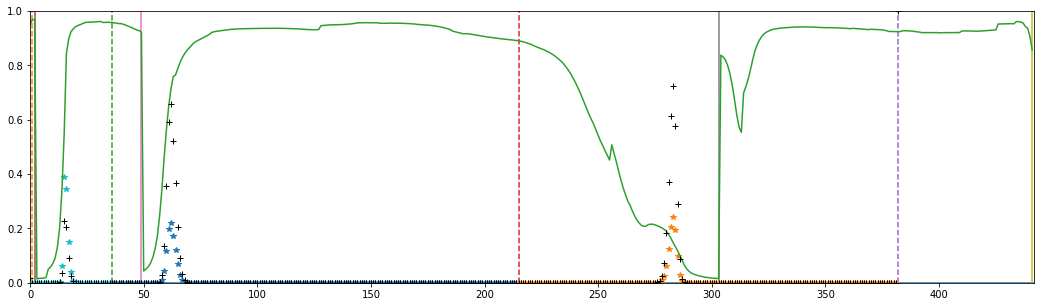

In [78]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in loaded_vidid_selected_frames[cur_vidid + ".txt"]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
    segment = segment.cpu().numpy()
    print(f"Min prob {i} = {np.min(segment).item()}")
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid + ".txt"][i], 
                   loaded_vidid_selected_frames[cur_vidid + ".txt"][i+1])
    plt.plot(xs, segment, '*')

    
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 
plt.plot(np.arange(item[1][idx].item()), plt_arr)


loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))
loss_arr = -loss_arr[0].detach().cpu().numpy()
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr/np.max(loss_arr), 'k+')

plt.ylim([0, ymax])
plt.xlim([0, item[1][idx].item()])

In [40]:
loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
print(loss_prob.shape)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))

torch.Size([1, 1895, 48])


In [43]:
loss_arr[0].shape

torch.Size([1387])

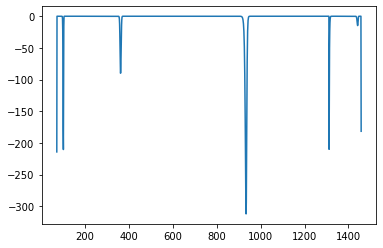

In [45]:
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr[0].detach().cpu().numpy())

In [44]:
es_loss

tensor(3.3987, device='cuda:0', dtype=torch.float64)

In [35]:
video_id_boundary_frames[cur_vidid], loaded_vidid_selected_frames[cur_vidid + ".txt"], item_1[idx]

([75, 345, 1305, 1415, 1440, 1519],
 [73, 282, 455, 1312, 1434, 1458],
 tensor(1520, device='cuda:0', dtype=torch.int32))

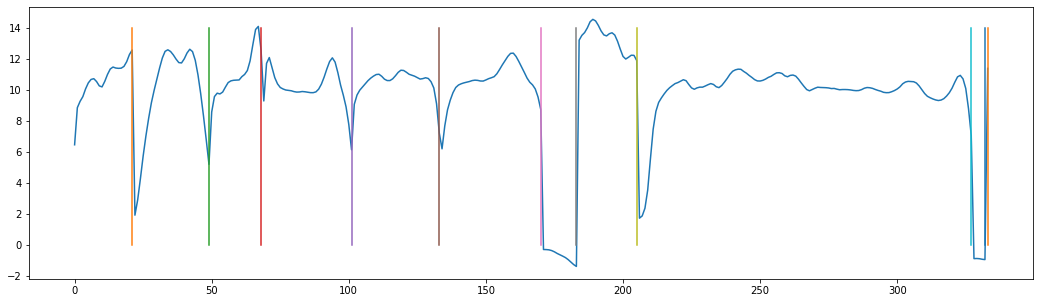

In [41]:
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 14])

torch.Size([334, 334])

In [37]:
cur_features_shortened = cur_vid_feat[:item[1][idx]]
cur_features_shortened[:, item[2][idx][:item[1][idx]]].shape
for

torch.Size([334, 334])

In [26]:
item[2][idx][video_id_boundary_frames[cur_vidid][1]-6:video_id_boundary_frames[cur_vidid][1]+9]

tensor([47, 47, 47, 47, 47, 47, 47,  4,  4,  4,  4,  4,  4,  4,  4])

In [25]:
video_id_boundary_frames[cur_vidid][0]-6,video_id_boundary_frames[cur_vidid][0]+9

6

In [27]:
cur_vid_feat[video_id_boundary_frames[cur_vidid][1]-7:video_id_boundary_frames[cur_vidid][1]+9][:,[47,4]]

tensor([[ 1.0794, 13.3350],
        [ 1.0831, 13.5102],
        [ 1.1767, 13.7662],
        [ 1.3750, 14.0177],
        [ 1.7298, 14.1727],
        [ 2.1706, 14.0367],
        [ 2.7338, 13.4563],
        [ 4.5600, 12.1745],
        [ 7.8450, 10.3246],
        [11.0151,  8.3563],
        [13.4775,  6.6546],
        [14.1836,  5.2898],
        [11.2142,  4.2791],
        [ 5.9829,  3.5694],
        [ 2.3440,  2.9389],
        [ 0.7406,  2.3515]], device='cuda:0')

In [19]:
def add_frames_and_get_classification_value(model_output, count_list, video_ids_list, labels_all, p_criterion):
    new_selected_frames = {}
#     new_selected_frames_probs_values = {}
#     new_selected_frames_labels = {}
    
    labels_arr = []
    probs_arr = []
    
    for i, video_id in enumerate(video_ids_list):
        current_boundary_frames = boundaries_dict[video_id]
        current_video_logits = model_output[i].T
        current_video_count = count_list[i]
        current_selected_frames = loaded_vidid_selected_frames[video_id]
        labels = labels_all[i]
        cur_seg_start = 0
        for seg_num, ele in enumerate(current_boundary_frames):
            cur_seg_end = ele + 1
            total_seg_len = cur_seg_end - cur_seg_start
            per_frames_far_from_boundary = int(0.3 * total_seg_len)
            new_frames_start = cur_seg_start + per_frames_far_from_boundary
            new_frames_end = cur_seg_end - per_frames_far_from_boundary
            
            frames_added = list(range(new_frames_start, new_frames_end))
            frames_added.append(current_selected_frames[seg_num])
            frames_added = list(set(frames_added))
            frames_added.sort()
            new_selected_frames[video_id] = frames_added

            
            labels_seg = torch.stack([labels[current_selected_frames[seg_num]]] * len(frames_added))
            frames_added = torch.tensor(np.array(frames_added), dtype=torch.long, device=current_video_logits.device)
            prob_seg = current_video_logits[frames_added, :]
            
            labels_arr.append(labels_seg)
            probs_arr.append(prob_seg)
            
            cur_seg_start = cur_seg_end
            
    labels_arr = torch.cat(labels_arr)
    probs_arr = torch.cat(probs_arr)
    loss = p_criterion(probs_arr, labels_arr)
    return loss